In [13]:
%load_ext line_profiler
import numpy as np
import pandas as pd
from astropy.io import ascii, fits
from scipy.stats import anderson_ksamp, ks_2samp
from halotools.sim_manager import HaloTableCache, CachedHaloCatalog
from halotools.empirical_models import PrebuiltSubhaloModelFactory
import random
import time

In [14]:
#number of times to sample COSMOS dwarf catalog
n_loops = 1

print n_loops, 'loops'

1 loops


In [15]:
#Bol-Planck model
simname = 'bolshoi-planck'
halo_finder = 'rockstar'
version_name = 'bplanck_dwarfs'
ptcl_version_name='bplanck_dwarfs_downsampled2'
ptcl_version_name='bplanck_dwarfs'

redshift = 0.278625 #(1/0.78209)-1 ; a=0.78209
Lbox, particle_mass = 250, 1.5e8

#read in halocat
cache = HaloTableCache()
halocat = CachedHaloCatalog(simname = simname, halo_finder = halo_finder,
                            version_name = version_name, redshift = redshift, ptcl_version_name=ptcl_version_name) # doctest: +SKIP

print(halocat.redshift) # doctest: +SKIP
print(halocat.ptcl_version_name) # doctest: +SKIP


model = PrebuiltSubhaloModelFactory('behroozi10', redshift=redshift,
                                    scatter_abscissa=[12, 15], scatter_ordinates=[0.4, 0.2])
model.populate_mock(halocat)

0.2786
bplanck_dwarfs


In [16]:
#COSMOS data
dwarf_sample_file = '/Users/fardila/Documents/GitHub/dwarf_lensing/Data/cosmos/dwarf_sample_for_paper.fits'

dwarf_sample_data  = fits.open(dwarf_sample_file)[1].data
dwarf_masses = dwarf_sample_data['mass_med']

In [17]:
min(dwarf_masses)

7.73324

In [18]:
max(dwarf_masses)

8.99998

In [121]:
#galaxy table limited to mass range of dwarfs
mock_galaxies = model.mock.galaxy_table
mock_galaxies = mock_galaxies['x', 'y', 'z', 'stellar_mass']
mock_galaxies = np.array(mock_galaxies[(np.log10(mock_galaxies['stellar_mass'])>=min(dwarf_masses)) & \
                              (np.log10(mock_galaxies['stellar_mass'])<9.0)])
#reduce size of table in half
half_mock_galaxies = np.random.choice(mock_galaxies,500000)

In [114]:
%timeit half_mock_galaxies.sort(order='stellar_mass')

1 loop, best of 3: 264 ms per loop


In [117]:
%timeit mock_galaxies[:500000].sort('stellar_mass')

1 loop, best of 3: 260 ms per loop


In [122]:
def find_nearest_new_indices_sorted(index, n, existing_indices, length):
    """
    index: index of closest value
    n: number of closest
    existing_indices: indices that already exist to avoid repeats

    return:
    indices of n nearest rows
    """
    
    #indices of nearest rows
    nearest_rows=[]
    
    #append index
    i=0
    if index not in existing_indices:
            nearest_rows.append(index)
    
    #append next nearest indices
    while len(nearest_rows) < n:
        
        if index + i not in existing_indices and index + i not in nearest_rows and index + i<length:
            nearest_rows.append(index + i)
       
        if len(nearest_rows) < n and index - i not in existing_indices and index - i not in nearest_rows and index - i>0:
            nearest_rows.append(index - i)
         
        i += 1
    
    return nearest_rows

def create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_nearest):
    """
    dwarf_masses: masses of COSMOS dwarfs
    mock_galaxies: array of mock galaxies from halotools
    n_nearest: number of nearest mock galaxies to use (i.e. number of times to
               sample full COSMOS dwarf catalog)

    return:
    array of the sample of mock dwarfs with an identical distribution
    of masses as COSMOS
    """
    
    #set for speeding up finding location
    subsample_indices=set()
    
    #sort first to speed up future calculations
    mock_galaxies.sort(order = 'stellar_mass')  
    
    #indices of nearest mock mass for each dwarf mass
    indices = np.searchsorted(mock_galaxies['stellar_mass'], 10**dwarf_masses)
    
    #add additional nearest
    for index in indices:   

        matched_indices = find_nearest_new_indices_sorted(index, n_loops, subsample_indices, len(mock_galaxies))

        subsample_indices.update(matched_indices)

        
    subsample = mock_galaxies[list(subsample_indices)]


    return subsample

In [93]:
subsample = create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 50)


In [101]:
%lprun -f find_nearest_new_indices_sorted create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 50)


In [ ]:
%lprun -f create_dwarf_catalog_with_matched_mass_distribution create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 50)


In [95]:
print 'subsample: ' + str(len(subsample))
print 'total mock galaxies: ' + str(len(mock_galaxies))
# print 'remaining mock galaxies: ' + str(len(mock_galaxies_pd[mock_galaxies_pd['stellar_mass']>0]))

#check that they are indistinguishable
#anderson_ksamp([subsample,dwarf_masses])
print ks_2samp(np.log10(subsample['stellar_mass']),dwarf_masses)

subsample: 343800
total mock galaxies: 1192318
Ks_2sampResult(statistic=0.0019371727748690448, pvalue=1.0)


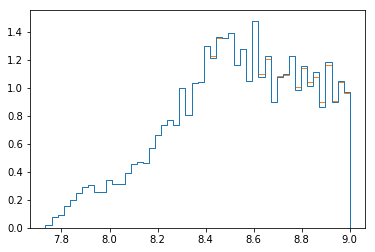

In [97]:
import matplotlib.pyplot as plt
plt.hist([dwarf_masses,np.log10(subsample['stellar_mass'])], bins =50, normed=True, histtype = 'step')
plt.show()

In [34]:
#convert to script
!jupyter nbconvert --to script optimize_sampling.ipynb

[NbConvertApp] Converting notebook optimize_sampling.ipynb to script
[NbConvertApp] Writing 4194 bytes to optimize_sampling.py


## Final notes: Length of mock catalog affect speed and number of loops possible in a few secs. Steep cost for reduced catalog size past a certain number of loops.

In [125]:
%timeit create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 30)

1 loop, best of 3: 1.45 s per loop


In [130]:
%timeit create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, mock_galaxies, n_loops = 35)

1 loop, best of 3: 1.64 s per loop


In [127]:
%timeit create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, half_mock_galaxies, n_loops = 30)

1 loop, best of 3: 1.09 s per loop


In [129]:
%timeit create_dwarf_catalog_with_matched_mass_distribution(dwarf_masses, half_mock_galaxies, n_loops = 35)

1 loop, best of 3: 1.95 s per loop
